In [1]:
import xarray as xr
import numpy  as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/m2data2/yycheng/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/m2data2/yycheng/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


绘制MPAS输出降水的时间序列，和CMORPH之间的对应，以及误差；便于说明问题绘制了分位数图<br>
因为CN05.1存在mask数据，因此需要对输出数据进行处理，用NCL+CDO来处理（在前一个文件夹，precip_preprocess中进行）<br>
2021.03.05<br>
    更新到进行气温数据的绘制

In [2]:
# 读取数据
# year = "2006"
# 注释掉的是原始数据，此后的是进行了mask之后的数据
# dir_vr = "/raid52/yycheng/MPAS/VR_postprocess/VR_merge/pre/" + "daily_pre_03-15.nc"
dir_vr = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/" + "mask_vr_t2m_03-15.nc"
ds_vr = xr.open_dataset(dir_vr)
# ds_vr

# dir_rcm = "/raid52/yycheng/MPAS/RCM_postprocess/RCM_merge/pre/" + "daily_pre_03-15.nc"
dir_rcm = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/mask_res/" + "mask_rcm_t2m_03-15.nc"
ds_rcm = xr.open_dataset(dir_rcm)
# ds_rcm

obs_cn051_tm  = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA/mask_t2m/" +  "sel_CN05.1_Tm_1961_2018_daily_025x025.nc"
ds_cn051_tm = xr.open_dataset(obs_cn051_tm)


# ds_cn051_time_loc_year = (ds_cn051.time.dt.year >= 2003) & (ds_cn051.time.dt.year <= 2015)
# ds_cn051_time_loc_month= (ds_cn051.time.dt.month>=    4) & (ds_cn051.time.dt.month <= 8)
# ds_cn051_sel = ds_cn051_tm.isel(time = ds_cn051_time_loc_year & ds_cn051_time_loc_month)

# ds_cmorph
# precip_obs = ds_disk["precip_CMORPH"]
# precip_mod = ds_disk["precip_MPAS"]
vr_mean         = ds_vr['t2m'].mean(dim=["longitude","latitude"])

rcm_mean        = ds_rcm['t2m'].mean(dim=["longitude","latitude"])

cn051_tm_mean  = ds_cn051_tm['tm'].mean(dim=['lon','lat'])

vr_mean     = vr_mean - 273.15

rcm_mean    =rcm_mean - 273.15


_mean 是不同数据的时间序列，下面将进行不同的groupby，绘制具体的序列

In [3]:
# 针对 day 的groupby + mean (dayofyear)

cn051_tm_dayofyear = cn051_tm_mean.groupby('time.dayofyear').mean('time')
vr_tm_dayofyear = vr_mean.groupby('Time.dayofyear').mean('Time')
rcm_tm_dayofyear = rcm_mean.groupby('Time.dayofyear').mean('Time')

# 选取一个特定年份
# sel_year = 2006
# cn051_dayofyear  =  cn051_mean[cn051_mean.time.dt.year==sel_year]
# cmorph_dayofyear =  cmorph_mean[cmorph_mean.time.dt.year==sel_year]
# vr_dayofyear     =  vr_mean[vr_mean.Time.dt.year==sel_year]
# rcm_dayofyear    = rcm_mean.loc[rcm_mean.Time.dt.year==sel_year] # 使用 .loc 和直接使用相同，因为是用


In [4]:

# ds_vr['precip_MPAS'].Time[(ds_vr.Time.dt.month>=5) & (ds_vr.Time.dt.month<=7)]
time_idx = pd.date_range(start = "2012-04-01", end = "2012-08-31",freq='d')
time_idx
# ds_vr.sel(Time = time_idx)

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10',
               ...
               '2012-08-22', '2012-08-23', '2012-08-24', '2012-08-25',
               '2012-08-26', '2012-08-27', '2012-08-28', '2012-08-29',
               '2012-08-30', '2012-08-31'],
              dtype='datetime64[ns]', length=153, freq='D')

In [5]:
# 将数据整理成pandas，准备绘图
df_cn051 = cn051_tm_dayofyear.to_dataframe()
df_vr  = vr_tm_dayofyear.to_dataframe()
df_rcm = rcm_tm_dayofyear.to_dataframe()

# rename df for plot
df_vr  = df_vr.rename(columns={"t2m":"vr"})
df_rcm = df_rcm.rename(columns={"t2m":"rcm"})
df_cn051 = df_cn051.rename(columns={"tm":"CN05.1"})

pd_plot = pd.concat([df_cn051, df_vr, df_rcm], axis=1)
pd_plot.head()

,CN05.1,vr,rcm
dayofyear,,,
91,5.488763,1.568440,1.568440
92,5.267538,0.002060,0.011728
93,5.727961,0.085686,0.159033
94,5.956830,0.272883,0.408753
95,6.166461,0.476898,0.720457


<Figure size 432x432 with 0 Axes>

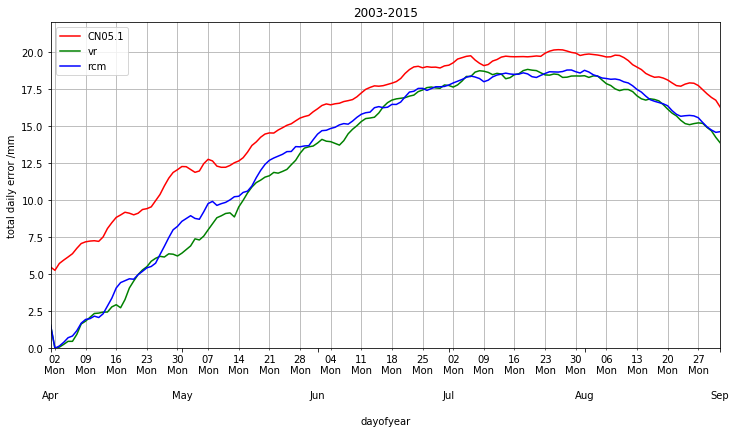

In [11]:
import matplotlib.dates as dates
# pd_plot = pd.concat([df_obs, df_mod,minus], axis=1)
plt.figure(figsize=(6,6))

ymin = 0.
ymax = 22.
idx = pd.date_range("2003-"+'04-01', "2003-"+'09-01')
# s = pd.Series(np.random.randn(len(idx)), index=idx)

# fig, ax = plt.subplots()
# ax.plot_date(idx.to_pydatetime(), 'v-')
ax = pd_plot.plot(figsize=(12,6),style=['-r','-g','-b'])
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n'))
# ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])
# plt.tight_layout()
# plt.show()
ax.set_ylabel("total daily error /mm")
plt.title("2003-2015")
plt.savefig("./output_pic/series_dayofyear.png")